<img src="../logo.png" align="right" width="150" />

#### Teoría de Circuitos II

# Trabajo Semanal 8
#### *Tobias Bavasso Piizzi*

La resolución detallada se puede encontrar [aquí](https://gitlab.frba.utn.edu.ar/tbavassopiizzi/tcii/-/blob/master/Tareas-Semanales/TrabajoSemanal8/TareaSemanal8.pdf) 



## Consigna
<img src="img/circuito.PNG" align="center" width="500" />

1. Construya el filtro analógico que se describe y proponga una estructura activa que permita lograrlo.
2. Aplicando la transformación bilineal, obtenga la transferencia H(z) en función de los coeficientes del filtro y la frecuencia de sampleo.
3. Estudio de las frecuencias de sampleo con warping.
- Compute la frecuencia de sampleo que genera un error del 5% en la frecuencia del cero analógico. ¿Qué error observa en la frecuencia analógica del polo?
- Compute la frecuencia de sampleo que genera un error del 5% en la frecuencia del polo analógico. ¿Qué error observa en la frecuencia analógica del cero?
- ¿Cuál es frecuencia de sampleo mínima teórica que puede utilizar?
- Suponga que utiliza una frecuencia de sampleo de 80KHz, ¿cómo quedaría la transferencia del filtro de pre énfasis tras aplicar el prewarping a la frecuencia del polo? ¿Qué error en dB tiene con respecto a la analógica a la frecuencia del cero?
4. (Utilice 80KHz como frencuencia de sampleo para los siguientes incisos)  Proponga una estructura para la implementación del filtro digital previamente computado.
5. Entendiendo que la señal analógica no esta acotada en banda y tiene un espectro como el que se ve en la imagen debajo, sabiendo que hay información hasta 20KHz:
- Compute el número de niveles de cuantización mínimo en función del espectro provisto. ¿Cuántos bits de cuantización se requieren?
- Describa el proceso de selección del filtro antialias. ¿Cuáles son las consideraciones de plantilla?




## 1. Filtro Analógico

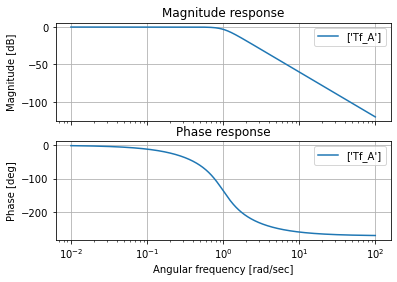

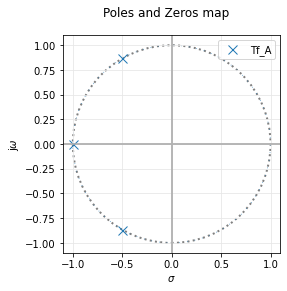

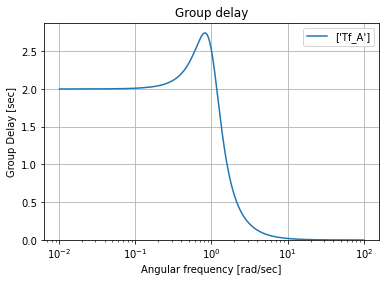

In [3]:
import scipy.signal as sig
import matplotlib as mpl
from splane import analyze_sys, pretty_print_lti , tfadd ,tfcascade
import numpy as np
import control.matlab as control
import matplotlib.pyplot as plt
import sys

num_a = [1]
den_a = [1,2,2,1]
tf_a = sig.TransferFunction(num_a,den_a)
analyze_sys( [tf_a], ["Tf_A"])


## 2. Transformación Bilineal

In [4]:
import sympy as sp
from splane import print_latex

s, z = sp.symbols('s z', complex=True)
k, fs, Q, Om = sp.symbols('k fs Q Om', real=True, positive=True)

Ts = 1/(s**3+s**2+s+1)
fz = k * (z-1)/(z+1)

Tz = sp.collect(sp.simplify(sp.expand(Ts.subs(s, fz))), z)

display(Tz)

(z**3 + 3*z**2 + 3*z + 1)/(-k**3 + k**2 - k + z**3*(k**3 + k**2 + k + 1) + z**2*(-3*k**3 - k**2 + k + 3) + z*(3*k**3 - k**2 - k + 3) + 1)

Resolviendo la transformada de forma manuscrita obtenemos el mismo resultado, pero su proceso es mucho más tedioso

<img src="./tfz.png" align="center" width="1000" />

## 3. Pre-Warp

Utilizaremos un función para realizar el **_Pre-Warp_**

Sin Pre-Warp 	 [0.04761905 0.14285714 0.14285714 0.04761905] 	 [ 1.         -1.19047619  0.71428571 -0.14285714] 	 1 

fs= 15490 wa= 1900.009965946782 w_d= 0.7706981731137253 

Con Pre-Warp @2K 	 [0.00023649 0.00070947 0.00070947 0.00023649] 	 [ 1.         -2.74230293  2.5167494  -0.77255456] 	 7.745 

fs= 154892 wa= 19000.005354482964 w_d= 0.7707341533431089 

Con Pre-Warp @20K 	 [2.65647277e-07 7.96941832e-07 7.96941832e-07 2.65647277e-07] 	 [ 1.         -2.97417609  2.94868455 -0.97450633] 	 77.446 



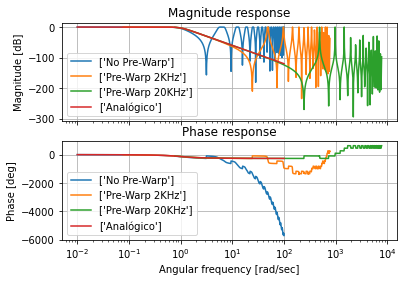

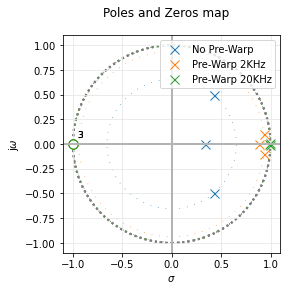

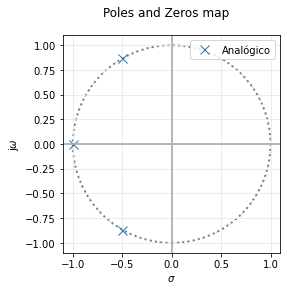

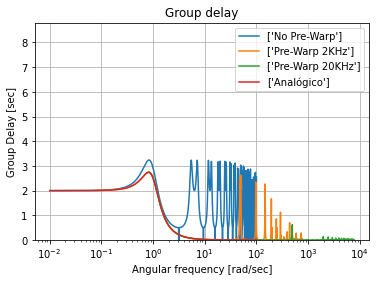

In [11]:
"""
Devuelve la fs nomrlizada para matchear fo con un error porcentual e a la hora de mapear digital

también devuelve como queda la w_analógico y w_digital
"""
def Pre_Warp(fo, e, fnorma):
    w_d = 0
    w_a = 0
    fs = fo
    w_d = 2*np.arctan(np.pi*fo/fs)
    w_a = w_d*fs/(2*np.pi)
    while(w_a < fo*e):
        fs = fs + 1
        w_d = 2*np.arctan(np.pi*fo/fs)
        w_a = w_d*fs/(2*np.pi)
    print("fs=",fs,"wa=",w_a,"w_d=",w_d,'\n')
    return(fs/fnorma)

num_a = [1]
den_a = [1,2,2,1]
frec_nor = 2e3

# Sin prewarp
fs = 1
num_z, den_z = sig.bilinear(num_a, den_a, fs)
print("Sin Pre-Warp",'\t',num_z,'\t',den_z,'\t',fs,'\n')
tf_z = sig.TransferFunction(num_z, den_z, dt=1/fs)


#Prewarp @2k 95%
fs = Pre_Warp(2000, 0.95,frec_nor)
num1_z, den1_z = sig.bilinear(num_a, den_a, fs)
print("Con Pre-Warp @2K",'\t',num1_z,'\t',den1_z,'\t',fs,'\n')
tf1_z = sig.TransferFunction(num1_z, den1_z, dt=(1/fs))

#Prewarp @20k 95%
fs = Pre_Warp(20000, 0.95,frec_nor)
num2_z, den2_z = sig.bilinear(num_a, den_a, fs)
print("Con Pre-Warp @20K",'\t',num2_z,'\t',den2_z,'\t',fs,'\n')
tf2_z = sig.TransferFunction(num2_z, den2_z, dt=(1/fs))

analyze_sys([tf_z,tf1_z,tf2_z,tf_a], ["No Pre-Warp","Pre-Warp 2KHz","Pre-Warp 20KHz","Analógico"])

Vemos que la _**frecuencia de muesstreo para hacer Pre-Warp sobre $f_{cero} = 2KHz$ es fs = 15490 Hz**_, cuando en papel iterando la definimos como aproximadamente fs = 16KHz.

Vemos que la _**frecuencia de muesstreo para hacer Pre-Warp sobre $f_{polo} = 20KHz$ es fs = 154892 Hz**_, cuando en papel iterando la definimos como aproximadamente fs = 160KHz.

También vemos como a medida que muestramos a una mayor frecuencia se copia con mayor fidelidad al filtro analógico muestreado, y también queda a la vista el movimiento de los polos según el Pre-Warp aplicado

Si ahora realizamos Pre-Warp con una frecuencia de muestreo fs=80KHz, obtendríamos un filtro como el siguiente, y vemos que el error es menor porque la frecuencia de muestreo es >> frecuencia de Nyquist 

Sampling @80K 	 [1.90490341e-06 5.71471024e-06 5.71471024e-06 1.90490341e-06] 	 [ 1.         -2.95000391  2.90124981 -0.95123066] 	 40.0 



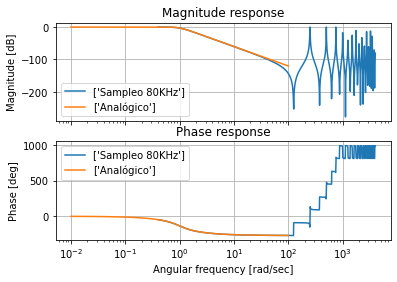

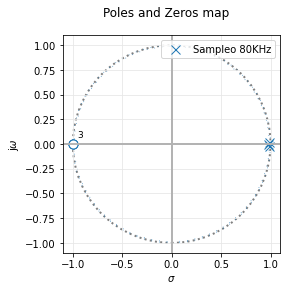

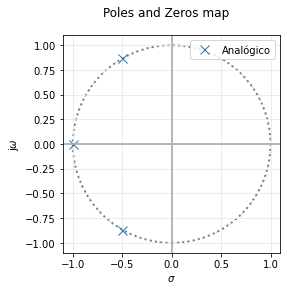

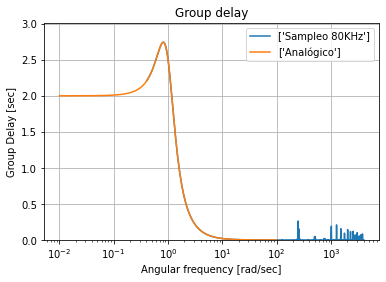

In [14]:
#Sampleo @80k
fs = 80e3/frec_nor
num3_z, den3_z = sig.bilinear(num_a, den_a, fs)
print("Sampling @80K",'\t',num3_z,'\t',den3_z,'\t',fs,'\n')
tf3_z = sig.TransferFunction(num3_z, den3_z, dt=(1/fs))

analyze_sys([tf3_z,tf_a], ["Sampleo 80KHz","Analógico"])

## 4. Implementación

In [17]:
s, z = sp.symbols('s z', complex=True)
k, fs, Q, Om = sp.symbols('k fs Q Om', real=True, positive=True)

Ts = 1/(s**3+s**2+s+1)
fz = k * (z-1)/(z+1)

Tz = sp.collect(sp.simplify(sp.expand(Ts.subs(s, fz))), z)

display(Tz.subs(k,2*80e3/2e3))

(z**3 + 3*z**2 + 3*z + 1)/(518481.0*z**3 - 1542317.0*z**2 + 1529523.0*z - 505679.0)

Esto puede llevarse fácilmente a una estructura canónica como se indica a continuación

<img src="./imple.png" align="center" width="1000" />